In [1]:
import sys
from pathlib import Path
sys.path.append('..')

from db import DB


d = DB.hgetall('adfr_biolip_0')
d

/usr/project/dlab/Users/jaden/PATH/benchmarking/../preprocessing.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  index = pd.read_csv(index_filename, delim_whitespace=True, skiprows=6, names=['PDB code', "resolution", "release year", "-logKd/Ki", "Kd/Ki", "slashes", "reference", "ligand name"])


{'error': 'False',
 'Binding affinity by manual survey of the original literature': 'nan',
 'attempted': 'True',
 'num_protein_atoms': '1631',
 'Ligand chain': 'A',
 'Binding site residues (with PDB residue numbering)': 'Y7 F8 V10 R13 W38 K44 G50 Q51 L52 P53 Q64 S65 Y108 G205',
 'PDB ID': '10gs',
 'Receptor chain': 'A',
 'Binding site residues (with residue re-numbered starting from 1)': 'Y6 F7 V9 R12 W37 K43 G49 Q50 L51 P52 Q63 S64 Y107 G204',
 'EC number': '2.5.1.18',
 'Protein File': '/usr/project/dlab/Users/jaden/BioLiP_updated_set/receptor/10gsA.pdb',
 "Catalytic site residues (different sites are separated by ';') (with residue re-numbered starting from 1)": 'Y6 R12',
 'Receptor sequence': 'PYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKASCLYGQLPKFQDGDLTLYQSNTILRHLGRTLGLYGKDQQEAALVDMVNDGVEDLRCKYISLIYTNYEAGKDDYVKALPGQLKPFETLLSQNQGGKTFIVGDQISFADYNLLDLLLIHEVLAPGCLDAFPLLSAYVGRLSARPKLKAFLASPEYVNLPINGNGKQ',
 'PubMed ID': '9398518.0',
 'UniProt ID': 'P09211',
 'Ligand serial number': '1',
 

In [2]:
from functional import seq
from tqdm import tqdm
from collections import defaultdict

results = seq(tqdm(range(50047))).map(lambda x: DB.hgetall(f'adfr_biolip_{x}')).map(lambda x: defaultdict(None, x)).list()

  0%|          | 0/50047 [00:00<?, ?it/s]

100%|██████████| 50047/50047 [01:06<00:00, 749.08it/s] 


In [3]:
results[1]

defaultdict(None,
            {'error': 'False',
             'Binding affinity by manual survey of the original literature': 'nan',
             'attempted': 'True',
             'num_protein_atoms': '1631',
             'Ligand chain': 'B',
             'Binding site residues (with PDB residue numbering)': 'Y7 F8 V10 R13 W38 K44 G50 Q51 L52 P53 Q64 S65 Y108 G205',
             'PDB ID': '10gs',
             'Receptor chain': 'B',
             'Binding site residues (with residue re-numbered starting from 1)': 'Y6 F7 V9 R12 W37 K43 G49 Q50 L51 P52 Q63 S64 Y107 G204',
             'EC number': '2.5.1.18',
             'Protein File': '/usr/project/dlab/Users/jaden/BioLiP_updated_set/receptor/10gsB.pdb',
             "Catalytic site residues (different sites are separated by ';') (with residue re-numbered starting from 1)": 'Y6 R12',
             'Receptor sequence': 'PYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKASCLYGQLPKFQDGDLTLYQSNTILRHLGRTLGLYGKDQQEAALVDMVNDGVEDLRCKYISLIYTNYEAGKDDYVKA

In [4]:
finished_results = seq(results) \
    .filter(lambda x: x.get('top_adfr_predicted_affinity (kcal/mol)') is not None) \
    .map(lambda x: dict({**x, 'top_adfr_predicted_affinity (kcal/mol)': float(x['top_adfr_predicted_affinity (kcal/mol)'])})) \
    .filter(lambda x: x.get('top_adfr_predicted_affinity (kcal/mol)') < 0 and x.get('top_adfr_predicted_affinity (kcal/mol)') > -30).list()

In [5]:
len(finished_results)

32044

In [6]:
import pandas as pd
df = pd.DataFrame(finished_results)

import re
import math
import numpy as np

def parse_molar_string(s):
    # Convert the value into M units
    conversion_factors = {
        "fM": 1e-15,
        "pM": 1e-12,
        "nM": 1e-9,
        "uM": 1e-6,
        "mM": 1e-3,
        "M": 1e0,
        "M^-1": 1e-1
        # Add other units as necessary
    }

    units_pattern = "|".join(map(re.escape, conversion_factors.keys()))

    # Extract the numeric value and unit from the string
    match = re.search(r"(\d+\.?\d*(?:[eE][+-]?\d+)?)(" + units_pattern + ")", s)

    if not match:
        # raise ValueError(f"Cannot parse the input string {s}")
        return np.NaN

    value = float(match.group(1))
    unit = match.group(2)

    if unit not in conversion_factors:
        raise ValueError(f"Unknown unit {unit} in string {s}")

    molar_value = value * conversion_factors[unit]

    # Compute the negative logarithm
    return -math.log10(molar_value)


moad_affinities = seq(df['Binding affinity provided by the Binding MOAD database'].to_list()).map(lambda x: parse_molar_string(x)).list()
pdbbind_affinities = seq(df['Binding affinity provided by the PDBbind-CN database'].to_list()).map(lambda x: parse_molar_string(x)).list()
binding_db_affinites = seq(df['Binding affinity provided by the BindingDB database'].to_list()).map(lambda x: parse_molar_string(x)).list()
manual_survey_affinities = seq(df['Binding affinity by manual survey of the original literature'].to_list()).map(lambda x: parse_molar_string(x)).list()

df['moad_affinities'] = moad_affinities
df['pdbbind_affinities'] = pdbbind_affinities
df['binding_db_affinities'] = binding_db_affinites
df['manual_survey_affinities'] = manual_survey_affinities

# Find indices where none of the three affinities are available

combined = list(zip(range(len(moad_affinities)), moad_affinities, pdbbind_affinities, binding_db_affinites, manual_survey_affinities))
all_nan_indices = seq(combined).filter(lambda x: x[1] is np.NaN and x[2] is np.NaN and x[3] is np.NaN and x[4] is np.NaN).map(lambda x: x[0]).list()

all_nan_indices  # Don't need to care about them - only two cases

# Scatter plot with matplotlib
# import matplotlib.pyplot as plt
# import numpy as np


# plt.scatter(range(len(all_finished_affinities)), all_finished_affinities)

[]

In [7]:
import numpy as np

# Constants
R = 8.3144621 # J/(mol*K)
T = 298.15 # K

def delta_G_to_pKd(delta_G):
    """ delta_G in kcal/mol, pKd in M
    """
    return -delta_G * 1000 / (R * T * np.log(10)) * 4.184

def pKd_to_delta_G(pKd):
    """ pKd in M, delta_G in kcal/mol
    """
    return -pKd * R * T * np.log(10) / 1000 / 4.184


df['moad_affinities (kcal/mol)'] = seq(df['moad_affinities'].to_list()).map(lambda x: pKd_to_delta_G(x)).list()
df['pdbbind_affinities (kcal/mol)'] = seq(df['pdbbind_affinities'].to_list()).map(lambda x: pKd_to_delta_G(x)).list()
df['binding_db_affinities (kcal/mol)'] = seq(df['binding_db_affinities'].to_list()).map(lambda x: pKd_to_delta_G(x)).list()
df['manual_survey_affinities (kcal/mol)'] = seq(df['manual_survey_affinities'].to_list()).map(lambda x: pKd_to_delta_G(x)).list()

/tmp/ipykernel_2836523/3326160233.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  binding_db_subset = binding_db_subset[binding_db_subset['binding_db_affinities (kcal/mol)'] < 0][binding_db_subset['top_adfr_predicted_affinity (kcal/mol)'] < 0][binding_db_subset['binding_db_affinities (kcal/mol)'] > -20][binding_db_subset['top_adfr_predicted_affinity (kcal/mol)'] > -20]
/tmp/ipykernel_2836523/3326160233.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  binding_db_subset = binding_db_subset[binding_db_subset['binding_db_affinities (kcal/mol)'] < 0][binding_db_subset['top_adfr_predicted_affinity (kcal/mol)'] < 0][binding_db_subset['binding_db_affinities (kcal/mol)'] > -20][binding_db_subset['top_adfr_predicted_affinity (kcal/mol)'] > -20]
/tmp/ipykernel_2836523/3326160233.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  binding_db_subset = binding_db_subset[binding_db_subset['bindin

Spearman correlation: SignificanceResult(statistic=0.2658556475822878, pvalue=1.4566065732054017e-217)


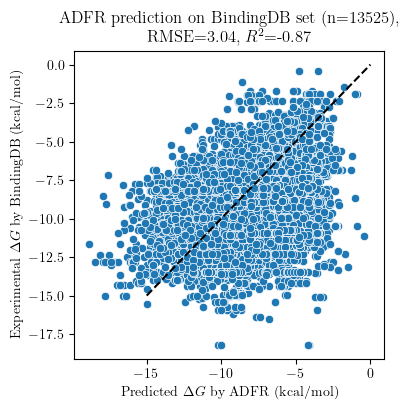

In [8]:
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "figure.figsize": (4, 4),
})

binding_db_subset = df[df['binding_db_affinities'].notna()]

# cleaned_df = cleaned_df[cleaned_df['experimental affinity (kcal/mol)'] < 0][cleaned_df['predicted_affinity_by_AA_Score (kcal/mol)'] < 0][cleaned_df['experimental affinity (kcal/mol)'] > -20][cleaned_df['predicted_affinity_by_AA_Score (kcal/mol)'] > -20]

# Remove outliers
binding_db_subset = binding_db_subset[binding_db_subset['binding_db_affinities (kcal/mol)'] < 0][binding_db_subset['top_adfr_predicted_affinity (kcal/mol)'] < 0][binding_db_subset['binding_db_affinities (kcal/mol)'] > -20][binding_db_subset['top_adfr_predicted_affinity (kcal/mol)'] > -20]

sns.scatterplot(data=binding_db_subset, x='top_adfr_predicted_affinity (kcal/mol)', y='binding_db_affinities (kcal/mol)')

RMSE = np.sqrt(np.mean((binding_db_subset['binding_db_affinities (kcal/mol)'] - binding_db_subset['top_adfr_predicted_affinity (kcal/mol)'])**2))
R2 = r2_score(binding_db_subset['binding_db_affinities (kcal/mol)'], binding_db_subset['top_adfr_predicted_affinity (kcal/mol)'])

plt.plot([-15, 0], [-15, 0], color='black', linestyle='--')
plt.title(f'ADFR prediction on BindingDB set (n={len(binding_db_subset)}),\nRMSE={RMSE:.2f}, $R^2$={R2:.2f}')
plt.xlabel(r'Predicted $\Delta G$ by ADFR (kcal/mol)')
plt.ylabel(r'Experimental $\Delta G$ by BindingDB (kcal/mol)')

print(f'Spearman correlation: {stats.spearmanr(binding_db_subset["top_adfr_predicted_affinity (kcal/mol)"], binding_db_subset["binding_db_affinities (kcal/mol)"])}')

plt.savefig('adfr_bindingdb.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2836523/1573666976.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  moad_subset = moad_subset[moad_subset['moad_affinities (kcal/mol)'] < 0][moad_subset['top_adfr_predicted_affinity (kcal/mol)'] < 0][moad_subset['moad_affinities (kcal/mol)'] > -20][moad_subset['top_adfr_predicted_affinity (kcal/mol)'] > -20]
/tmp/ipykernel_2836523/1573666976.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  moad_subset = moad_subset[moad_subset['moad_affinities (kcal/mol)'] < 0][moad_subset['top_adfr_predicted_affinity (kcal/mol)'] < 0][moad_subset['moad_affinities (kcal/mol)'] > -20][moad_subset['top_adfr_predicted_affinity (kcal/mol)'] > -20]
/tmp/ipykernel_2836523/1573666976.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  moad_subset = moad_subset[moad_subset['moad_affinities (kcal/mol)'] < 0][moad_subset['top_adfr_predicted_affinity (kcal/mol)'] < 0][moad_subset['moad_affinitie

Spearman correlation: SignificanceResult(statistic=0.37373586886643706, pvalue=0.0)


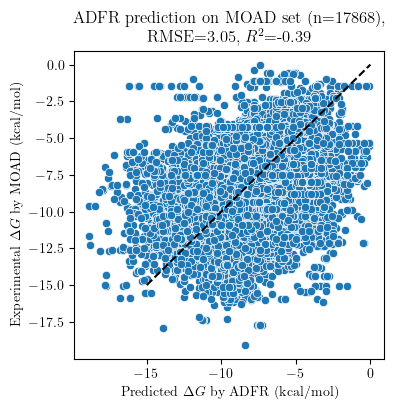

In [9]:
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "figure.figsize": (4, 4),
})


moad_subset = df[df['moad_affinities'].notna()]
# cleaned_df = cleaned_df[cleaned_df['experimental affinity (kcal/mol)'] < 0][cleaned_df['predicted_affinity_by_AA_Score (kcal/mol)'] < 0][cleaned_df['experimental affinity (kcal/mol)'] > -20][cleaned_df['predicted_affinity_by_AA_Score (kcal/mol)'] > -20]

moad_subset = moad_subset[moad_subset['moad_affinities (kcal/mol)'] < 0][moad_subset['top_adfr_predicted_affinity (kcal/mol)'] < 0][moad_subset['moad_affinities (kcal/mol)'] > -20][moad_subset['top_adfr_predicted_affinity (kcal/mol)'] > -20]
sns.scatterplot(data=moad_subset, x='top_adfr_predicted_affinity (kcal/mol)', y='moad_affinities (kcal/mol)')

RMSE = np.sqrt(np.mean((moad_subset['moad_affinities (kcal/mol)'] - moad_subset['top_adfr_predicted_affinity (kcal/mol)'])**2))
R2 = r2_score(moad_subset['moad_affinities (kcal/mol)'], moad_subset['top_adfr_predicted_affinity (kcal/mol)'])

plt.plot([-15, 0], [-15, 0], color='black', linestyle='--')
plt.title(f'ADFR prediction on MOAD set (n={len(moad_subset)}),\nRMSE={RMSE:.2f}, $R^2$={R2:.2f}')
plt.xlabel(r'Predicted $\Delta G$ by ADFR (kcal/mol)')
plt.ylabel(r'Experimental $\Delta G$ by MOAD (kcal/mol)')

print(f'Spearman correlation: {stats.spearmanr(moad_subset["top_adfr_predicted_affinity (kcal/mol)"], moad_subset["moad_affinities (kcal/mol)"])}')

plt.savefig('adfr_moad.png', dpi=300, bbox_inches='tight')